# Cadwell et al. dataset

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io

import glmnet_python
from glmnet import glmnet

import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

In [2]:
%%time

# LOAD ALL THE DATA FROM THE ORIGINAL FILES

data = pd.read_excel('cadwellData/Data_CortexInterneurons.xlsx', sheet_name="readcounts")
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

varGenes = pd.read_excel('https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S3.xlsx')
varGenes = varGenes.values[3:,-1]
varGenes = np.array([g[1:-1] for g in varGenes])
lgenes = list(genes)
counts = counts[:, [lgenes.index(g) for g in varGenes]]

from scipy import io
mat = io.loadmat('../data/cadwell-natbiotech/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

cols = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ephysProperties = ['V_rest', 'R_input', 'AP tau', 'AP thresh', 'AP width', 'AP amp', 'AHP', 'ADP', 
                   'Adapt', 'ifDelayed', 'ifBurst']
ephys = np.zeros((idxs.size, len(cols)))
for j,c in enumerate(cols):
    ephys[:,j] = [mat['cell'][0][i][c][0][0] for i in range(len(mat['cell'][0]))]

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
keep = (idxs != 44) & (idxs != 45) & ~np.isnan(np.sum(ephys,axis=1))
types = types[keep]
idxs  =  idxs[keep]
ephys = ephys[keep]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

cadwell = {'counts': counts, 'ephys': ephys, 'cellTypes': types, 
           'ephysNames': ephysProperties, 'genes': varGenes}

# Double-check
print('counts table shape:', cadwell['counts'].shape)
print('ephys shape:', cadwell['ephys'].shape)
print('cellTypes shape:', cadwell['cellTypes'].shape)
print('ephys properties:', ', '.join(cadwell['ephysNames']))
print('genes:', ', '.join(cadwell['genes'][:10]), '...')

counts table shape: (44, 15074)
ephys shape: (44, 11)
cellTypes shape: (44,)
ephys properties: V_rest, R_input, AP tau, AP thresh, AP width, AP amp, AHP, ADP, Adapt, ifDelayed, ifBurst
genes: Tac2, Mbp, Penk, Npy, Sparc, Sln, Cxcl14, Egr4, Cacng5, Npy2r ...
CPU times: user 17.8 s, sys: 76 ms, total: 17.9 s
Wall time: 17.9 s


In [3]:
# Plotting parameters for Cadwell data

colors = np.zeros((5,3))
colors[0,:] = [217,95,2]
colors[-1,:] = [27,158,119]
for i in range(1,4):
    colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
colors = colors/256

cellTypeColors = dict(zip(range(1,6), colors))
cellTypeLabels = dict(zip(range(1,6), ['NGC', None, None, None,'SBC']))

cadwell['colors'] = cellTypeColors
cadwell['labels'] = cellTypeLabels

In [4]:
# Preprocessing

# Library size normalization and log transform
X = cadwell['counts'] / np.sum(cadwell['counts'], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:,:3000]

Y = cadwell['ephys']

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

<IPython.core.display.Javascript object>


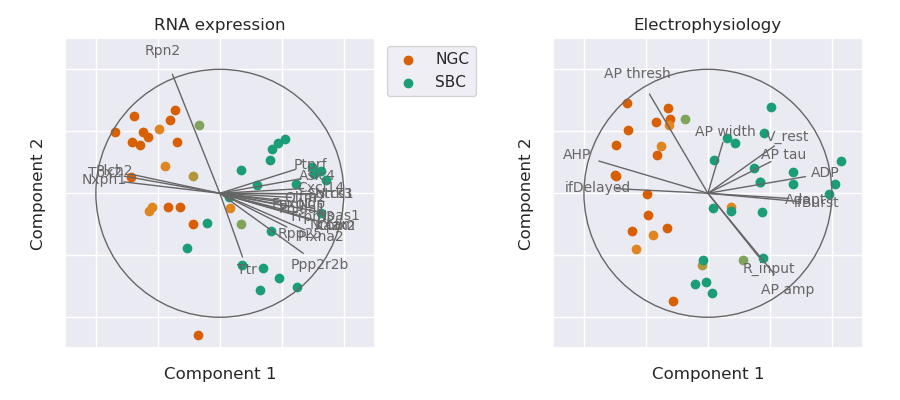

In [11]:
# RRR

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha = .5, lambdau = 1.5)

sparseRRR.bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'],
         cellTypes=cadwell['cellTypes'], cellTypeColors=cadwell['colors'], cellTypeLabels = cadwell['labels'],
         YdimsNames=cadwell['ephysNames'], XdimsNames=cadwell['genes'],
         xylim = 2.5)

<IPython.core.display.Javascript object>


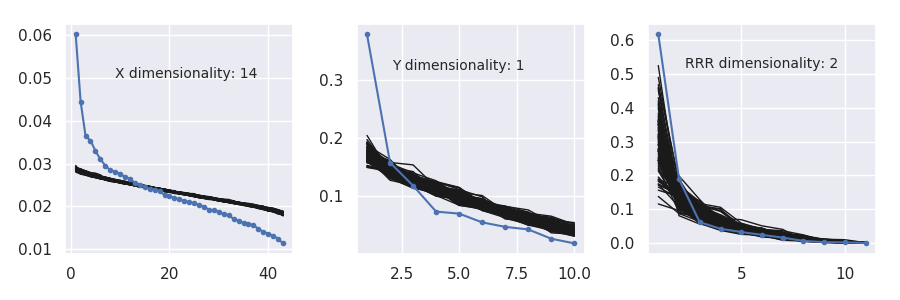

In [104]:
sparseRRR.dimensionality(X, Y)

<IPython.core.display.Javascript object>


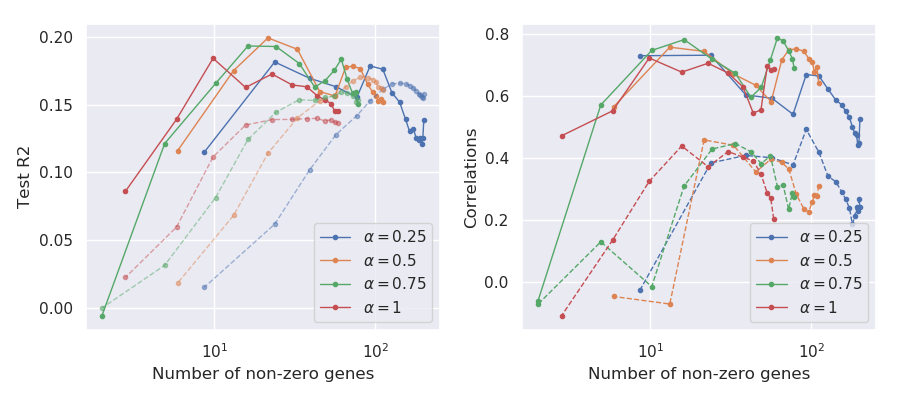

In [27]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,11)])
alphas = [.25, .5, .75, 1]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps=1, rank=2, folds=11)

sparseRRR.plot_cv_results(r2, r2_relaxed, nonzeros, corrs, corrs_relaxed, alphas)

1........... Time: 0.0h  6m 22s


<IPython.core.display.Javascript object>


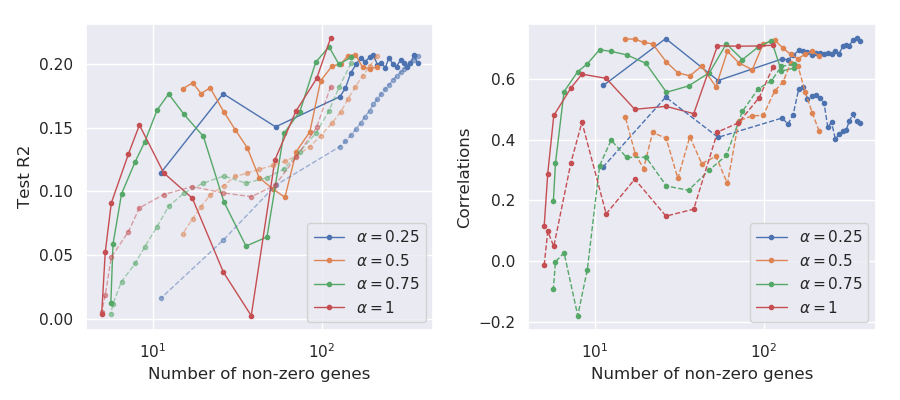

In [6]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,11)])
alphas = [.25, .5, .75, 1]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps=1, rank=5, folds=11)

sparseRRR.plot_cv_results(r2, r2_relaxed, nonzeros, corrs, corrs_relaxed, alphas)